In [1]:
include("./param.jl");
include("./aux_functions.jl");

2021-05-20 22:22:32.657222: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll


In [2]:
using Main.aux_functions
using Main.param

In [3]:
using ADCME
using SparseArrays

using DelimitedFiles
using Dates
using Plots

In [4]:
param_model_val = param_model(N_steps=10);
tf_variables, h_t, q_t_x, q_t_y = Darcy_flow_solver(param_model_val);
momment2, y_x_list, y_y_list = load_QoIs(param_model_val);

In [5]:
loss,dw_2, opt_ADAM, opt_LFGS, opt_ADAM_sum, opt_LFGS_sum, diff_eval,p_pre_soft_max, p = Info_upscale(tf_variables,param_model_val,q_t_x, q_t_y,50)

2.830469177224561e-5C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\inde

(PyObject <tf.Tensor 'truediv_177:0' shape=() dtype=float64>, PyObject <tf.Tensor 'add_73:0' shape=() dtype=float64>, PyObject <tf.Operation 'Adam' type=NoOp>, PyObject <tensorflow.contrib.opt.python.training.external_optimizer.ScipyOptimizerInterface object at 0x0000000095C85208>, PyObject <tf.Operation 'Adam_1' type=NoOp>, PyObject <tensorflow.contrib.opt.python.training.external_optimizer.ScipyOptimizerInterface object at 0x00000000A40B7FC8>, PyObject <tf.Tensor 'Max_1:0' shape=() dtype=float64>, PyObject <tf.Variable 'Variable_2:0' shape=(1, 64) dtype=float64_ref>, PyObject <tf.Tensor 'Softmax:0' shape=(1, 64) dtype=float64>)

In [6]:
sess = Session(); init(sess);


2021-05-20 22:23:11.314071: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2021-05-20 22:23:11.318458: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2021-05-20 22:23:11.344921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: GeForce GTX 1650 major: 7 minor: 5 memoryClockRate(GHz): 1.56
pciBusID: 0000:01:00.0
2021-05-20 22:23:11.344944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cudart64_100.dll
2021-05-20 22:23:11.347435: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cublas64_100.dll
2021-05-20 22:23:11.349930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library cufft64_100.dll
2021-05-20 22:23:11.350907: I tensorflow/stream_

In [7]:
run(sess,dw_2)*1e5

0.0010029600540841202

In [8]:

T_ = 1e10
# ScipyOptimizerMinimize(sess, opt_LFGS_sum,feed_dict = Dict(tf_variables.lambda => ones(1)*T_,tf_variables.N_k_dis=>N_k_dis_))
BFGS!(sess,dw_2*1e5,options=Dict("maxiter"=> 12, "ftol"=>1e-18, "gtol"=>1e-18))

# for i=1:100


# print(i)
# run(sess,opt_ADAM_sum)
# end

C:\Users\dbeli\.julia\adcme\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
┌ Info: Optimization starts...
└ @ ADCME C:\Users\dbeli\.julia\packages\ADCME\cupNK\src\optim.jl:332
iter 0, current loss=0.0010029600540841202
iter 1, current loss=0.0009135701970346239
iter 2, current loss=0.0006289409325656148
================ STEP 0 ===============
iter 3, current loss=0.0002738925945656959
================ STEP 1 ===============
iter 4, current loss=0.000131112843742627
================ STEP 2 ===============
iter 5, current loss=5.8227537307790955e-5
================ STEP 3 ===============
iter 6, current loss=2.6353591626739935e-5
================ STEP 4 ===============
iter 7, current loss=1.2579194986422497e-5
================ STEP 5 ===============
iter 8, current l

12-element Vector{Any}:
 0.0006289409325656148
 0.0002738925945656959
 0.000131112843742627
 5.8227537307790955e-5
 2.6353591626739935e-5
 1.2579194986422497e-5
 7.247551816099717e-6
 5.4742865039239555e-6
 5.026715750177092e-6
 4.956084192035044e-6
 4.950879712565356e-6
 4.950320621496529e-6

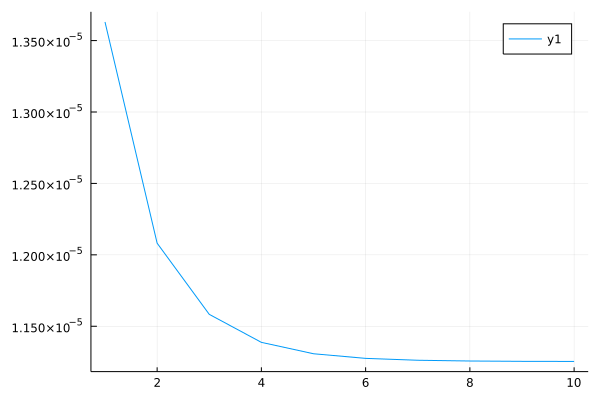

In [9]:
plot(mean(y_x_list[5],dims=1)[1,:])

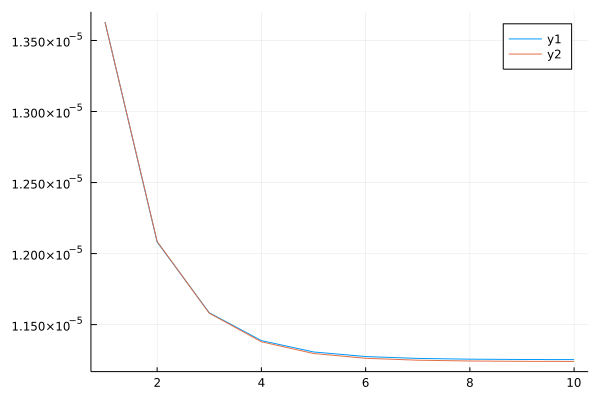

In [10]:
plot!(run(sess,q_t_x)[5][:,2,1])



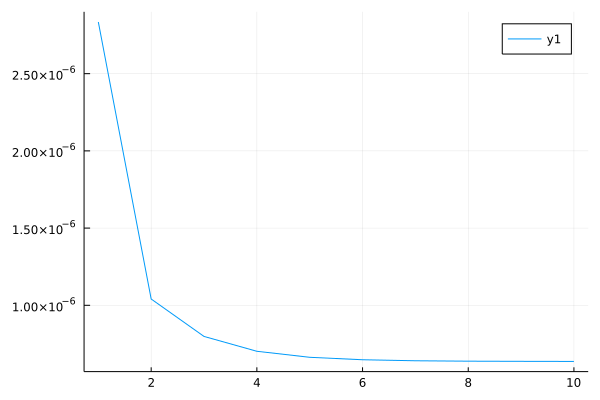

In [11]:
plot(mean(y_y_list[5],dims=1)[1,:])

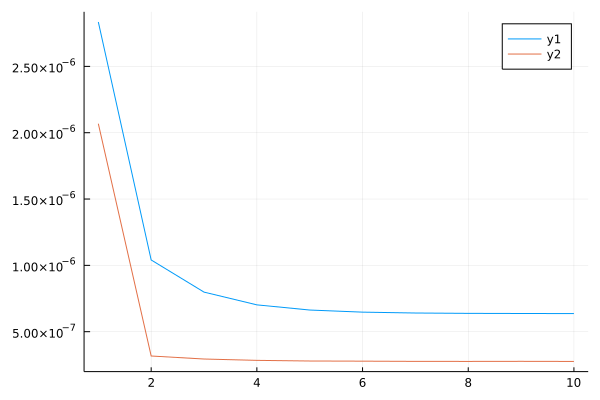

In [12]:
plot!(run(sess,q_t_y)[5][:,2,1])


In [20]:
aux_functions.multiply_K(sess,param_model_val,tf_variables,+2*log(10))

64×10 Matrix{Float64}:
  6.26612e-5  -8.35481e-5  -5.27498e-5  …  -6.20238e-6   3.93168e-5
 -4.05471e-5  -1.41992e-5   6.9259e-5      -8.46312e-5  -5.41294e-6
 -1.38326e-5   7.01398e-5  -2.20616e-5     -2.33342e-5   7.98895e-5
  8.05821e-5   2.73952e-5   4.1595e-5      -7.2608e-5    1.61685e-5
 -4.17219e-5  -5.5976e-5    2.5067e-5       6.1533e-5    3.37824e-6
  8.42709e-5   7.15562e-5   3.24105e-5  …   2.95442e-5   5.08854e-5
 -8.42806e-5   1.71802e-5   7.27337e-5     -7.94699e-6  -2.03121e-5
  2.71574e-5  -5.31714e-5   7.13751e-5     -6.41292e-5  -8.6991e-5
  9.09899e-5  -6.7011e-5    8.65105e-5      7.96222e-5   7.24406e-5
 -6.76011e-5   1.31568e-5   2.29907e-5      2.90256e-5  -6.5817e-5
  7.39198e-5  -9.17477e-5  -7.3439e-6   …  -6.17996e-5  -4.61055e-5
  2.76102e-5   4.81469e-5   8.17958e-5     -3.17686e-5  -8.58819e-7
  6.56573e-5   7.19488e-5   7.98714e-5     -7.4345e-5    2.93289e-5
  ⋮                                     ⋱               
  6.13619e-5   5.59782e-5  -2.40222e-5

In [10]:
# check = run(sess,q_t_x)

In [12]:
# flow_x,flow_y,loss_save,loss_y_save = run(sess,[q_t_x,q_t_y,dw_2,loss])

# flow_x_save = flow_x[5][:,4,1]
# flow_y_save = flow_y[5][:,4,1]
# exp_name = "loss_y_minus_function_check_"
# open(string(exp_name,"flow_x.txt"),"w") do io
#     writedlm(io, flow_x_save)
# end

# open(string(exp_name,"flow_y.txt"),"w") do io
#     writedlm(io, flow_y_save)
# end

# open(string(exp_name,"loss.txt"),"w") do io
#     writedlm(io, loss_save)
# end

# open(string(exp_name,"loss_y.txt"),"w") do io
#     writedlm(io, loss_y_save)
# end





In [13]:



# for i = 1:20

#         aux_functions.multiply_K(sess,param_model_val,tf_variables,+log(1.1))
#         flow_x,flow_y,loss_save,loss_y_save = run(sess,[q_t_x,q_t_y,dw_2,loss])


#         flow_x_save = flow_x[5][:,4,1]
#         flow_y_save = flow_y[5][:,4,1]

        
        
#         open(string(exp_name,"flow_x.txt"),"a") do io
#                 writedlm(io, flow_x_save)
#         end

#         open(string(exp_name,"flow_y.txt"),"a") do io
#                 writedlm(io, flow_y_save)
#         end

#         open(string(exp_name,"loss.txt"),"a") do io
#                 writedlm(io, loss_save)
#         end

#         open(string(exp_name,"loss_y.txt"),"a") do io
#                 writedlm(io, loss_y_save)
#         end
# end